# Alternate Z02FH Analysis Approach

In [41]:
import re
def ExtractTC(x):
    return re.search("_D(\d{3})",x)[1]

print(ExtractTC('MB_U01_MZ02F_D420'))

def ExtractUUT(x):
    return "U"+re.search("_U(\d{2})",x)[1]
    
print(ExtractUUT('MB_U01_MZ02F_D420'))


def Maccor_parser(x):
    days = float(re.search("(.+?)d",x)[1])
    hours= re.search("(?<=d)(.*)",x)[1].strip()
    h =    float(re.search("(\d*)(?=:)",hours)[1])
    m =    float(re.search("(?<=:)(\d*)",hours)[1])
    s =    float(re.search("(?<=:\d\d:)(.*)",hours)[1])
    return (days*1440+h*60+m+s/60)/60

print(Maccor_parser('4d 22:25:6.53000020980835')) # Test pattern

420
U01
118.41848055561383


In [42]:
# This is an intersting alternate approach for reading in the battery data
import glob
import os
import pandas as pd
from pathlib import Path
from functools import partial

prs = partial(pd.read_csv, 
              sep="\t", 
              header=0, 
              skiprows=4, 
              usecols=['Rec#','Cyc#','Step','TestTime','StepTime','Amp-hr','Amps','Volts','State']
             )
path=os.path.join(os.getcwd(), "Z02_Test")  # This reminds me of what I have to do with PQ
files = Path(path).glob('*.txt')            # Making a path object provides all sorts of great methods

df = pd.concat((prs(f).assign(filename=f.stem) for f in files), ignore_index=True)
df.StepTime=df.StepTime.apply(Maccor_parser)
df.TestTime=df.TestTime.apply(Maccor_parser)
df= (df
 .assign(UUT = lambda x:x['filename'].apply(ExtractUUT),
         TC  = lambda x:x['filename'].apply(ExtractTC)
        )
 .drop('filename',axis=1)
 .rename(columns={"filename": "Test_Case","Rec#":"Rec","Cyc#":"Cyc"})
 .set_index('Rec')    
    )
df['UUT'] = df.UUT.astype('category')
df['TC'] = df.TC.astype('category')
df['State'] = df.State.astype('category')

In [43]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47299 entries, 1 to 7143
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Cyc       47299 non-null  int64   
 1   Step      47299 non-null  int64   
 2   TestTime  47299 non-null  float64 
 3   StepTime  47299 non-null  float64 
 4   Amp-hr    47299 non-null  float64 
 5   Amps      47299 non-null  float64 
 6   Volts     47299 non-null  float64 
 7   State     47299 non-null  category
 8   UUT       47299 non-null  category
 9   TC        47299 non-null  category
dtypes: category(3), float64(5), int64(2)
memory usage: 3.0 MB


,Cyc,Step,TestTime,StepTime,Amp-hr,Amps,Volts
count,47299.000000,47299.000000,47299.000000,47299.000000,47299.000000,47299.000000,47299.000000
mean,2.891541,5.246094,49.790410,9.367530,0.005035,0.000937,3.876463
std,1.274327,0.755510,32.572441,7.023250,0.003381,0.001587,0.222132
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.999920
25%,2.000000,5.000000,21.736697,2.866678,0.002060,0.000500,3.736400
50%,3.000000,5.000000,44.591467,8.400003,0.004670,0.000500,3.847330
75%,4.000000,5.000000,77.237535,15.083344,0.007780,0.000500,4.033455
max,5.000000,12.000000,118.492333,25.140089,0.012570,0.012300,4.350350


In [44]:
df = df.query("Cyc==2 and State=='D' and Step==5")
df


,Cyc,Step,TestTime,StepTime,Amp-hr,Amps,Volts,State,UUT,TC
Rec,,,,,,,,,,
566,2,5,9.251697,0.000003,0.00000,0.0000,4.17685,D,U01,420
567,2,5,9.268364,0.016669,0.00001,0.0005,4.16815,D,U01,420
568,2,5,9.285031,0.033336,0.00002,0.0005,4.16587,D,U01,420
569,2,5,9.301697,0.050003,0.00002,0.0005,4.16419,D,U01,420
570,2,5,9.318364,0.066669,0.00003,0.0005,4.16274,D,U01,420
...,...,...,...,...,...,...,...,...,...,...
2793,2,5,46.372522,25.033344,0.01252,0.0005,3.12810,D,U03,435
2794,2,5,46.389189,25.050011,0.01253,0.0005,3.09773,D,U03,435
2795,2,5,46.405856,25.066678,0.01253,0.0005,3.06180,D,U03,435


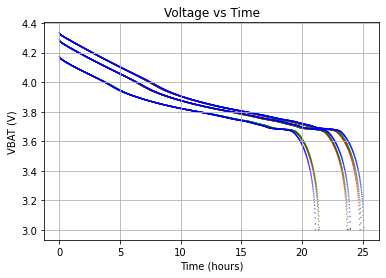

In [45]:
import matplotlib.pyplot as plt
zz = {'U01':'red','U02':'green','U03':'blue'}
df.plot.scatter(x='StepTime',
                y='Volts',
                c=df['UUT'].map(zz),
                s=0.1
              )
plt.title('Voltage vs Time')
plt.xlabel('Time (hours)')
plt.ylabel('VBAT (V)')
plt.grid()

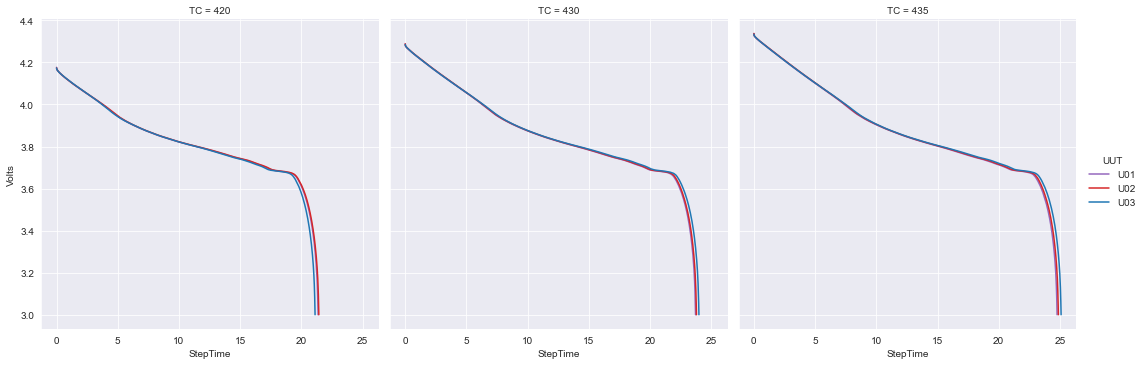

In [56]:
import seaborn as sns
palette={'U01':'tab:purple','U02':'tab:red','U03':'tab:blue'}
sns.set_style("darkgrid")
p = sns.relplot(kind='line', data=df, col='TC', x='StepTime', y='Volts', hue='UUT', palette=palette)